У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

# Лінійна регресія: перенавчання і регуляризація

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [3]:

df = pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

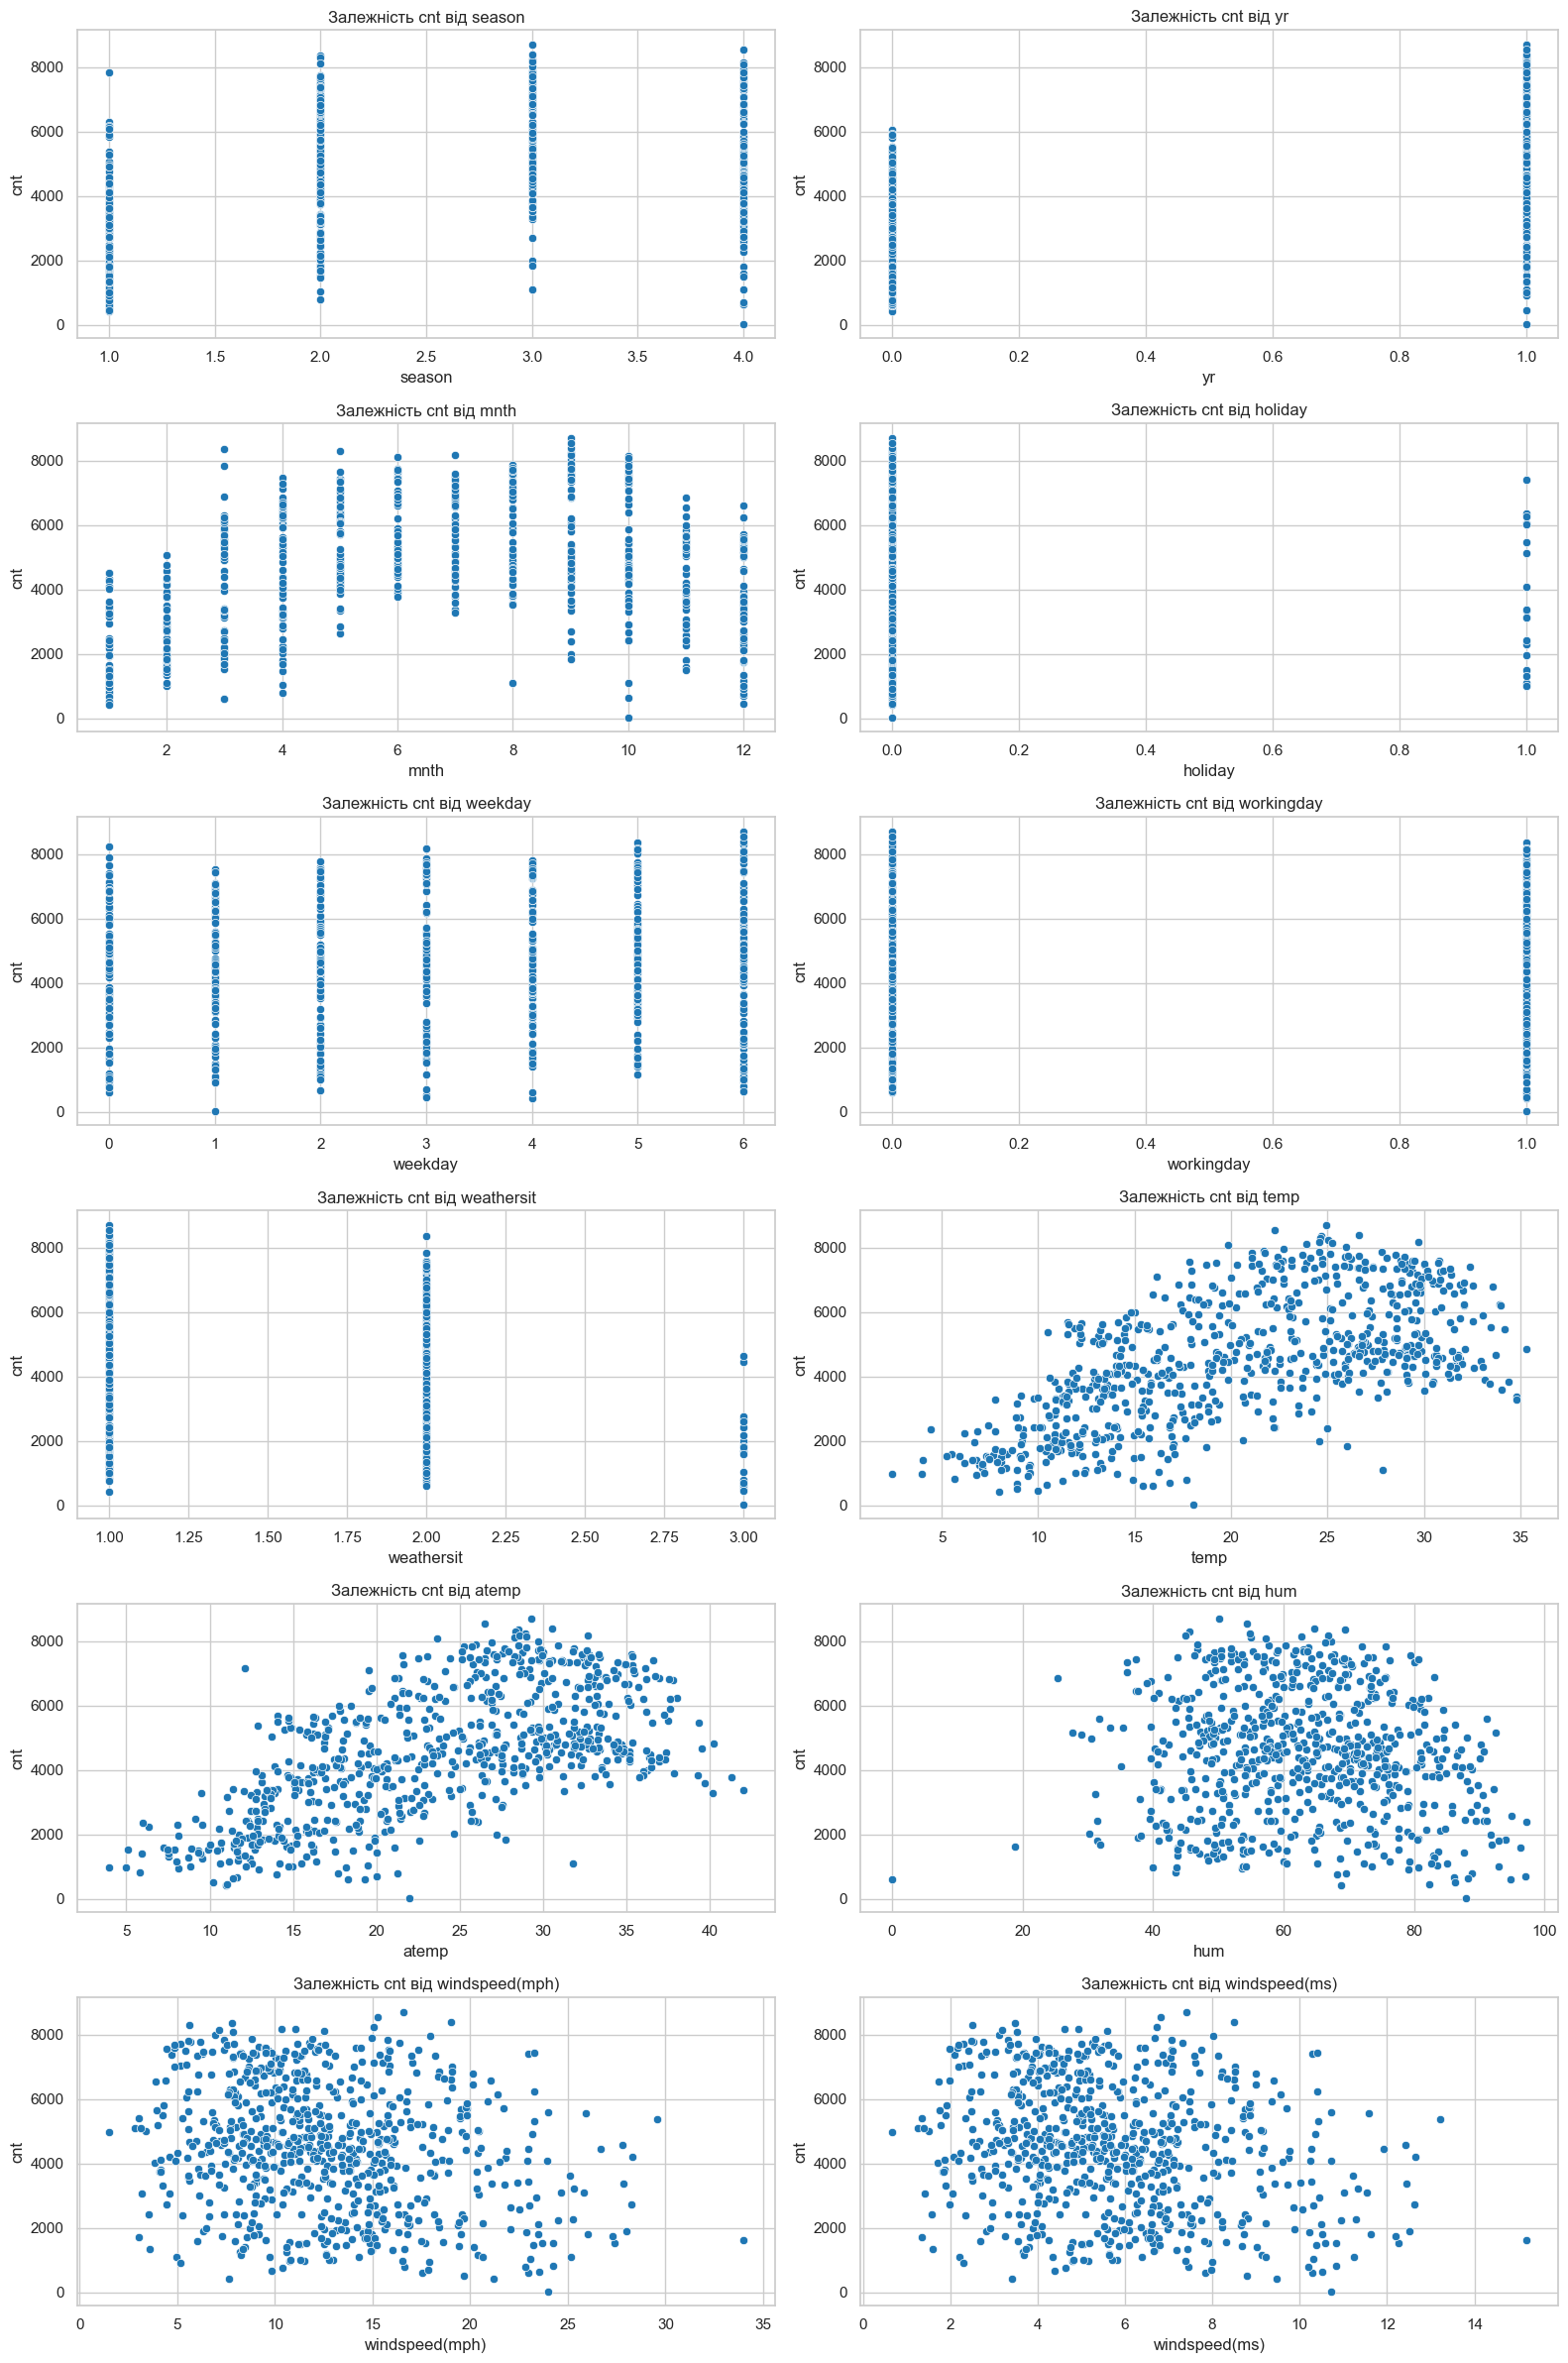

In [18]:
features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']
sns.set_context("notebook", font_scale=1)
sns.set_style("whitegrid")
plt.figure(figsize=(16, 24))
for i, feature in enumerate(features[:12]):
    plt.subplot(6, 2, i + 1)
    sns.scatterplot(data=df, x=feature, y='cnt')
    plt.title(f'Залежність cnt від {feature}')
plt.tight_layout()
plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

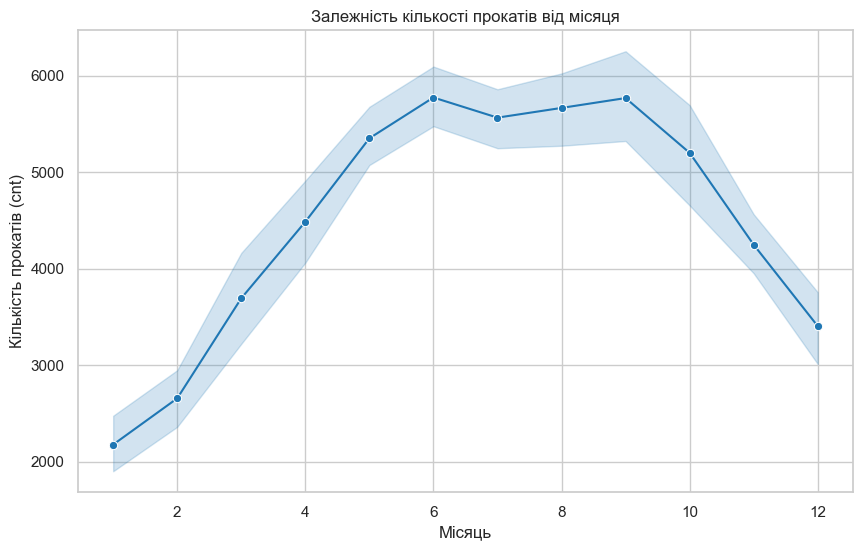

In [16]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='mnth', y='cnt', marker='o')
plt.title('Залежність кількості прокатів від місяця')
plt.xlabel('Місяць')
plt.ylabel('Кількість прокатів (cnt)')
plt.grid(True)
plt.show()

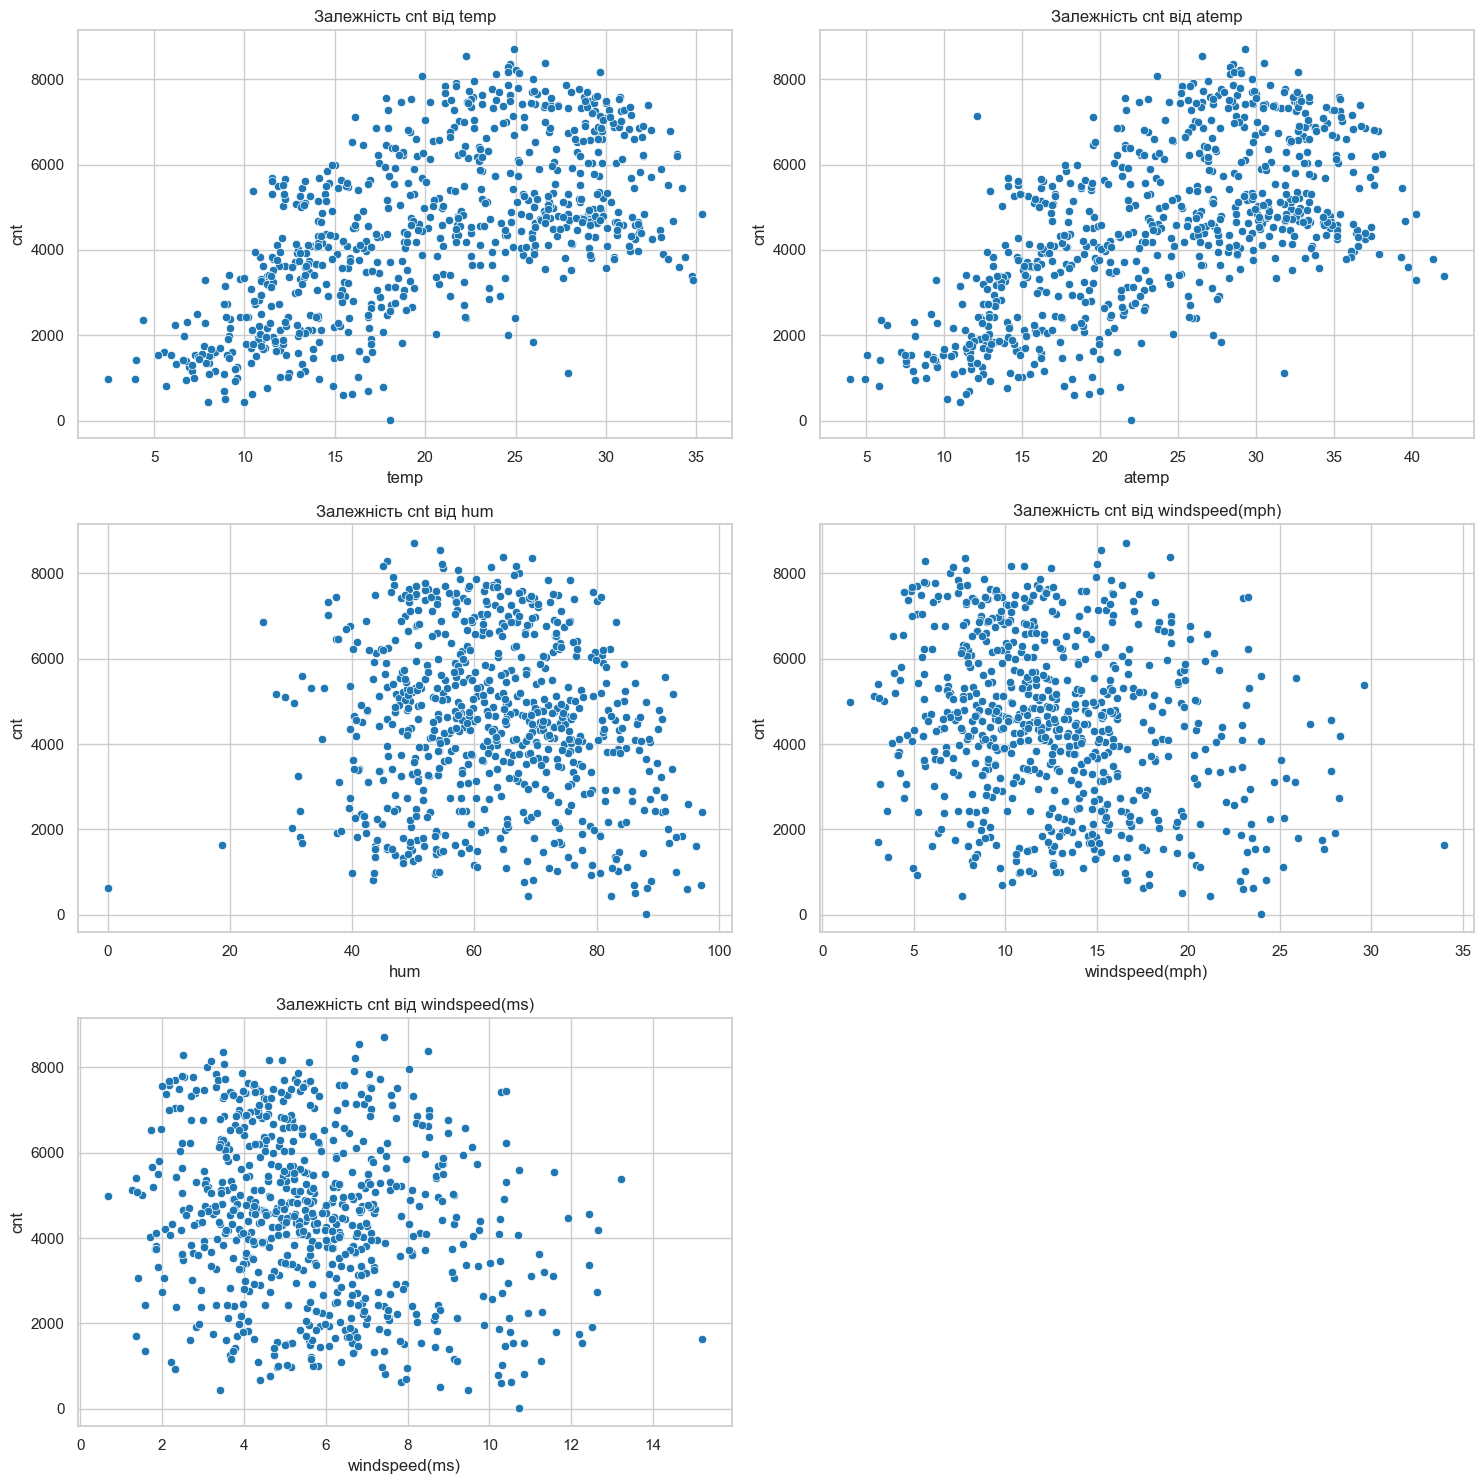

In [17]:
numeric_features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']
plt.figure(figsize=(15, 15))
for i, feature in enumerate(numeric_features):
    plt.subplot(3, 2, i + 1)
    sns.scatterplot(data=df, x=feature, y='cnt')
    plt.title(f'Залежність cnt від {feature}')
    plt.xlabel(feature)
    plt.ylabel('cnt')
    plt.grid(True)
plt.tight_layout()
plt.show()


## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

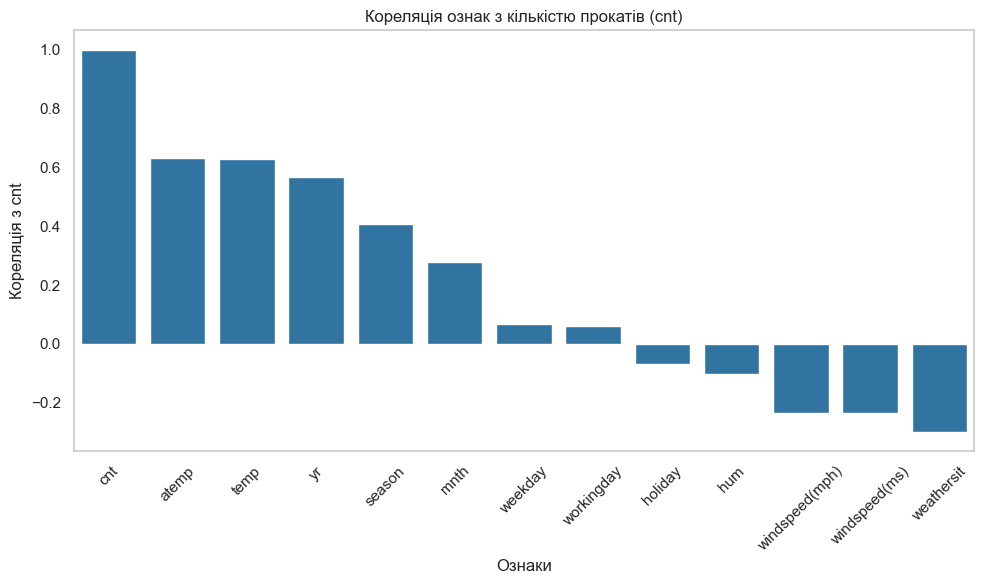

In [22]:
correlation_with_target = df.corrwith(df['cnt'])
correlation_with_target.sort_values(ascending=False, inplace=True)
correlation_with_target

plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values)
plt.title('Кореляція ознак з кількістю прокатів (cnt)')
plt.xlabel('Ознаки')
plt.ylabel('Кореляція з cnt')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

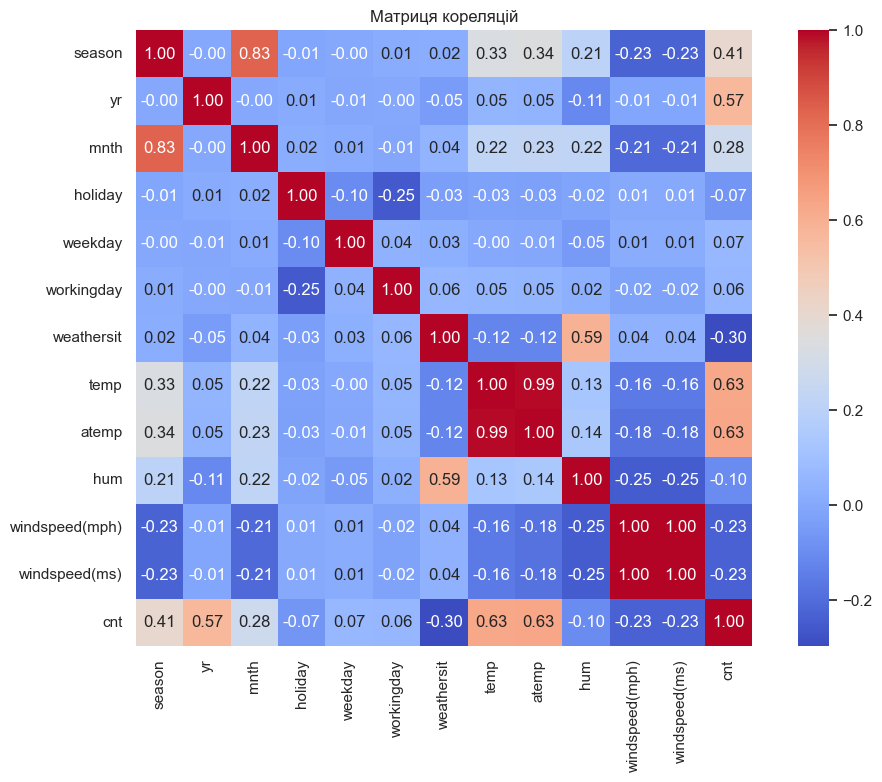

In [23]:
correlation_matrix = df.corr()
correlation_matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Матриця кореляцій')
plt.show()

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [24]:
selected_features = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']]
pairwise_correlation = selected_features.corr(method='pearson')
pairwise_correlation

,temp,atemp,hum,windspeed(mph),windspeed(ms)
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [26]:
maen_values = df.mean()
maen_values

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [27]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [89]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]
df_shuffled.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
703,2,1,4,0,3,1,1,0.253011,0.362887,-1.112269,-0.122813,-0.122813,6436
33,2,1,6,0,4,1,1,0.585567,0.583901,-0.427249,-0.427869,-0.427869,7494
300,3,0,7,0,5,1,2,1.168683,1.204356,0.913521,0.447322,0.447322,4040
456,3,0,7,0,4,1,1,1.013790,0.987107,-1.065428,0.647955,0.647955,5084
633,2,0,5,0,4,1,2,0.193785,0.223445,1.417035,-1.062346,-1.062346,4575


Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [98]:
X = df.drop('cnt', axis=1)
y = df['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [99]:
model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
coefficients = model.coef_

weights = zip(X.columns, coefficients)
for feature, weight in weights:
    print(f'Feature: {feature}, Weight: {weight}')

Feature: season, Weight: 522.9884252109102
Feature: yr, Weight: 2022.948164549441
Feature: mnth, Weight: -48.675735164961225
Feature: holiday, Weight: -480.0098270244078
Feature: weekday, Weight: 64.07843887277964
Feature: workingday, Weight: 150.46250893159353
Feature: weathersit, Weight: -589.534025007451
Feature: temp, Weight: 423.49554520444497
Feature: atemp, Weight: 579.6057890615862
Feature: hum, Weight: -150.14294255967437
Feature: windspeed(mph), Weight: 18062982010501.32
Feature: windspeed(ms), Weight: -18062982010707.668


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [107]:
from sklearn.linear_model import Ridge, Lasso

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

lasso_coefficients = lasso_model.coef_
lasso_weights = zip(X.columns, lasso_coefficients)
lasso_weights_output = {feature: weight for feature, weight in lasso_weights}
lasso_weights_output

{'season': np.float64(513.3185573371851),
 'yr': np.float64(2015.1339883477203),
 'mnth': np.float64(-45.044283781305744),
 'holiday': np.float64(-481.78179208891044),
 'weekday': np.float64(65.41848632945951),
 'workingday': np.float64(147.0207000128846),
 'weathersit': np.float64(-596.2023930012143),
 'temp': np.float64(441.7044715671179),
 'atemp': np.float64(561.7138655714125),
 'hum': np.float64(-149.76313813512107),
 'windspeed(mph)': np.float64(-205.0972453819943),
 'windspeed(ms)': np.float64(-3.132503590545697e-08)}

Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [118]:
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)
ridge_coefficients = ridge_model.coef_
ridge_weights = zip(X.columns, ridge_coefficients)
ridge_weights_output = {feature: weight for feature, weight in ridge_weights}
ridge_weights_output

{'season': np.float64(513.391554635483),
 'yr': np.float64(2014.1319135630763),
 'mnth': np.float64(-45.075032767130715),
 'holiday': np.float64(-481.90729968072145),
 'weekday': np.float64(65.46204672968398),
 'workingday': np.float64(147.3994011155105),
 'weathersit': np.float64(-595.9987752789804),
 'temp': np.float64(431.94608414592807),
 'atemp': np.float64(571.4502630867005),
 'hum': np.float64(-150.0834877381778),
 'windspeed(mph)': np.float64(-102.50303873350434),
 'windspeed(ms)': np.float64(-102.50303954829425)}

### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [129]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    coefs_lasso.append(lasso_model.coef_)

for idx, alpha in enumerate(alphas):
    coefs_ridge.append(ridge_model.coef_)


coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

coefs_lasso.shape, coefs_ridge.shape


((10, 12), (10, 12))

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

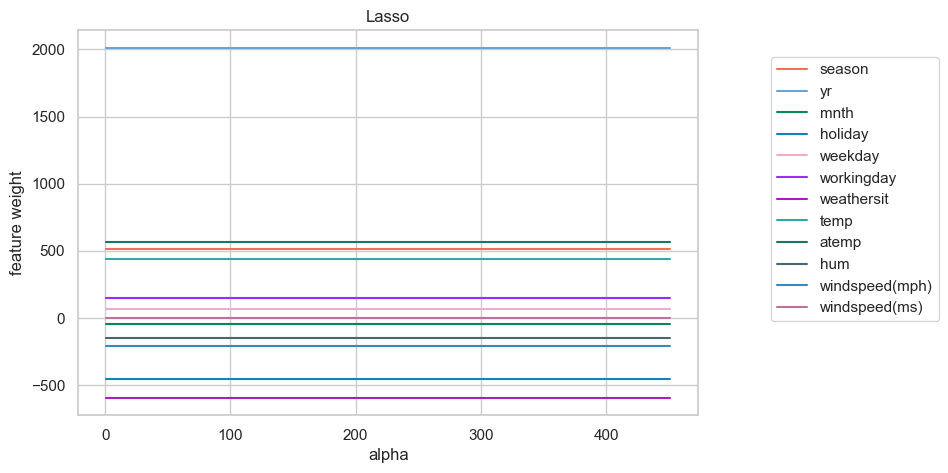

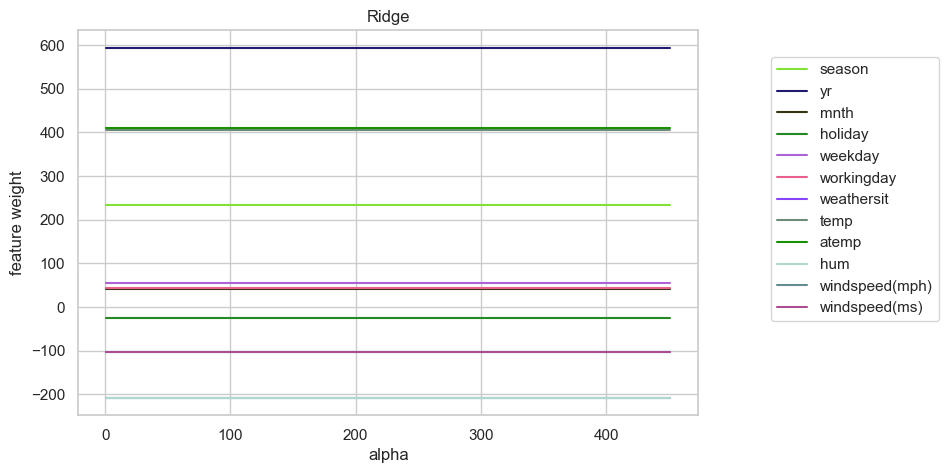

In [130]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

Відповідь:
1. - Lasso (L1 регуляризація) агресивніше зменшує ваги, оскільки він має здатність повністю зануляти деякі з них. Це відбувається завдяки додаванню суми абсолютних значень ваг до функції втрат. У результаті, менш значущі ознаки отримують вагу, яка дорівнює нулю.
- Ridge (L2 регуляризація) тільки зменшує ваги, але не обнуляє їх, оскільки до функції втрат додається квадрат ваги. Це означає, що Ridge намагається рівномірно зменшити всі ваги, але жоден із них не буде рівним нулю.
2. Якщо alpha стане дуже великим, Lasso значно збільшить штраф за великі ваги, і, як результат, багато з них стануть рівними нулю. Це відбувається тому, що функція втрат намагається мінімізувати суму абсолютних значень ваг. Коли штраф занадто великий, єдиним способом це зробити є занулення багатьох ваг, що фактично виключає відповідні ознаки з моделі
3. - Lasso: Так, Lasso може виключити одну з ознак windspeed(mph) або windspeed(ms) при певному значенні alpha > 0. Це відбувається тому, що Lasso здатний занулити деякі ваги, особливо коли ознаки сильно корельовані.
- Ridge: Ridge не виключає жодної ознаки при будь-якому значенні alpha > 0, оскільки він просто зменшує ваги, але ніколи не робить їх рівними нулю. У випадку корельованих ознак він зменшить їх значущість, але обидві ознаки залишаться в моделі.
4. - Lasso підходить краще для відбору неінформативних ознак, оскільки він може занулити їх ваги, ефективно виключаючи з моделі. Це робить його корисним для автоматичного відбору найважливіших ознак, відкидаючи ті, які не вносять значний внесок у результат.

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [131]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

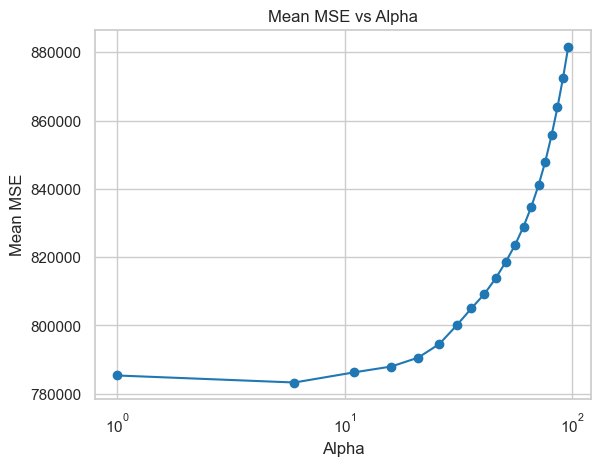

In [144]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3, random_state=42)
regressor.fit(X, y)

mean_mse = np.mean(regressor.mse_path_, axis=1)

def create_plot(alphas, mean_mse):
    plt.figure(figsize=(10,6))
x = map(lambda x: x, regressor.alphas_)
y = map(lambda mse: mse, mean_mse)
plt.plot(regressor.alphas_, mean_mse, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE')
plt.title('Mean MSE vs Alpha')
plt.grid(True)
plt.show()

In [147]:
best_alpha = regressor.alpha_

coefficient = pd.Series(regressor.coef_, index=X.columns)
best_alpha, coefficient

(np.int64(6),
 season            4.937278e+02
 yr                2.017204e+03
 mnth             -3.428242e+01
 holiday          -3.106703e+02
 weekday           6.907087e+01
 workingday        1.107583e+02
 weathersit       -5.892682e+02
 temp              3.660465e+02
 atemp             5.876298e+02
 hum              -1.456284e+02
 windspeed(mph)   -1.936034e+02
 windspeed(ms)    -2.340508e-08
 dtype: float64)

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


In [153]:
mse_path = regressor.mse_path_
min_mse_alphas = [regressor.alphas_[np.argmin(mse_path[:, i])]for i in range(mse_path.shape[1])]
min_mse_alphas, mse_path.shape



([np.int64(6), np.int64(6), np.int64(1)], (20, 3))

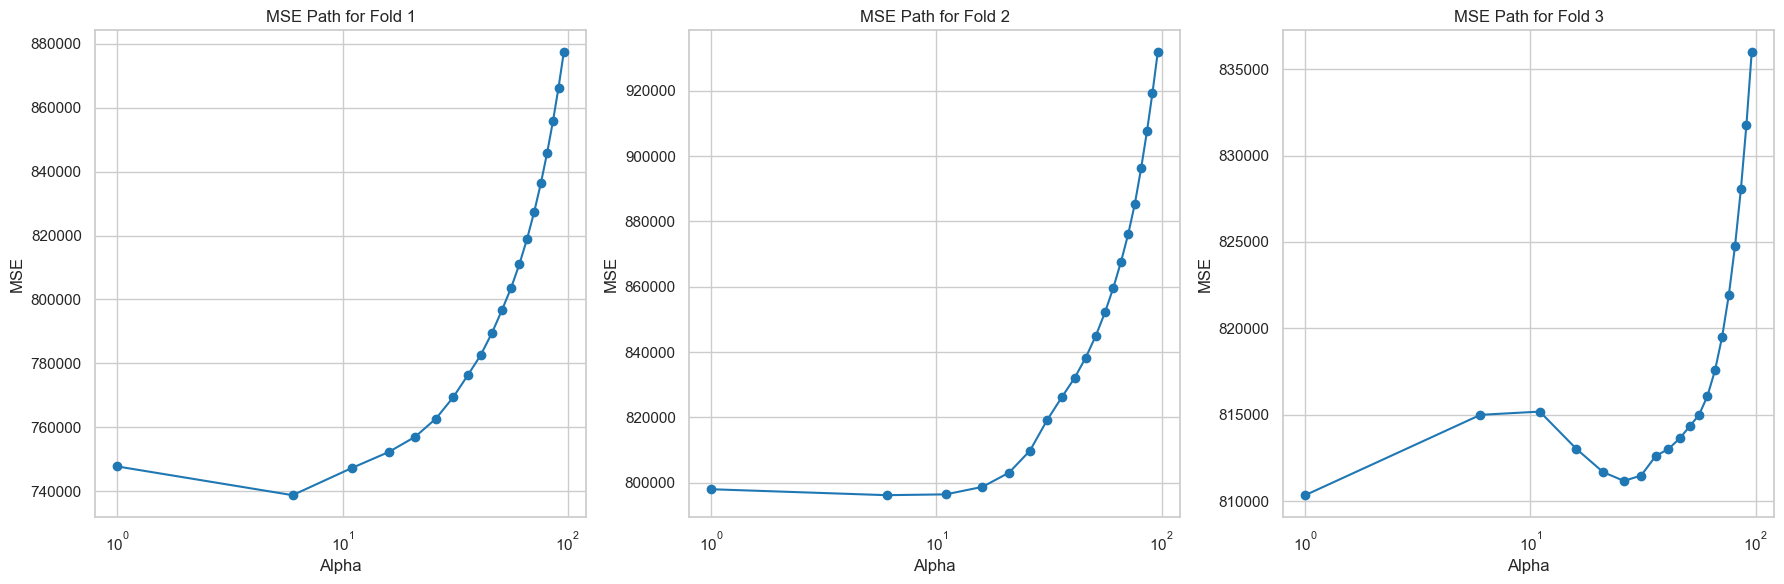

In [154]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
for i in range(3): 
    axes[i].plot(regressor.alphas_, mse_path[:, i], marker='o', linestyle='-') 
    axes[i].set_xscale('log') 
    axes[i].set_xlabel('Alpha') 
    axes[i].set_ylabel('MSE') 
    axes[i].set_title(f'MSE Path for Fold {i + 1}') 
    axes[i].grid(True) 
 
plt.tight_layout() 
plt.show()

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

In [150]:
top_features = coefficient.sort_values(ascending=False).head(4)
top_features

yr        2017.203874
atemp      587.629752
season     493.727813
temp       366.046520
dtype: float64

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

In [151]:
bottom_features = coefficient.sort_values(ascending=True).head(3)
bottom_features

weathersit       -589.268210
holiday          -310.670257
windspeed(mph)   -193.603371
dtype: float64

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [152]:
near_zero_features = coefficient[abs(coefficient) < 1e-3]
near_zero_features

windspeed(ms)   -2.340508e-08
dtype: float64

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.